<a href="https://colab.research.google.com/github/ilhamAdhim/ML-Book-Recommendation/blob/master/Book_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

In [605]:
!pip install opendatasets

In [606]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import tensorflow as tf

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity


# Importing layers from keras. Use LSTM for input layer, and Dense for hidden and output layer
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

# Import Adam Optimizers
from tensorflow.keras.optimizers import Adam

# Import for splitting test and training data set
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import  EarlyStopping

import opendatasets as od

In [607]:
od.download("https://www.kaggle.com/justinnguyen0x0x/best-books-of-the-21st-century-dataset")

Skipping, found downloaded files in "./best-books-of-the-21st-century-dataset" (use force=True to force download)


In [608]:
df_book_list = pd.read_csv('/content/best-books-of-the-21st-century-dataset/Best_Book_21st.csv', parse_dates=True, squeeze=True)
df_book_list

,id,title,series,author,book_link,genre,date_published,publisher,num_of_page,lang,review_count,rating_count,rate,award
0,0,The Martian,\n (The Martian #1)\n,Andy Weir,https://www.goodreads.com/book/show/18007564-t...,"Science Fiction,Fiction,Audiobook,Adventure,Sp...",February 11th 2014,"Crown\n\n ,",384.0,English,"77,156","919,781",4.40,Kurd-Laßwitz-Preis for Bestes ausländisches We...
1,1,Under the Banner of Heaven: A Story of Violent...,NaN,Jon Krakauer,https://www.goodreads.com/book/show/10847.Unde...,"Nonfiction,Religion,History,Crime,True Crime,M...",2004,"Pan MacMillan\n\n ,",400.0,English,"10,981","173,895",3.98,Colorado Book Award for General Nonfiction (2004)
2,2,Cutting for Stone,NaN,Abraham Verghese,https://www.goodreads.com/book/show/3591262-cu...,"Fiction,Historical,Historical Fiction,Cultural...",February 3rd 2009,"Alfred A. Knopf\n\n ,",541.0,English,"26,253","353,365",4.29,"PEN/Hemingway Foundation Award Nominee (2010),..."
3,3,We Need to Talk About Kevin,NaN,Lionel Shriver,https://www.goodreads.com/book/show/80660.We_N...,"Fiction,Contemporary,Thriller,Horror,Mystery,C...",July 3rd 2006,"Harper Perennial\n\n ,",400.0,English,"14,787","187,639",4.04,Orange Prize for Fiction (2005)
4,4,The Immortal Life of Henrietta Lacks,NaN,Rebecca Skloot,https://www.goodreads.com/book/show/6493208-th...,"Nonfiction,Science,History,Biography,Health,Me...",February 2nd 2010,"Crown Publishing Group\n\n ,",370.0,English,"36,574","646,155",4.07,Ambassador Book Award for American Studies (20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,10013,"Edge of Passion (Stealth Guardians, #1)",\n (Stealth Guardians #1)\n,Tina Folsom,https://www.goodreads.com/book/show/13516444-e...,"Fantasy,Paranormal,Romance,Romance,Paranormal ...",March 7th 2012,NaN,NaN,English,102,"1,011",4.01,NaN
10014,10014,Tales from a Not-So-Popular Party Girl (Dork D...,\n (Dork Diaries #2)\n,Rachel Renée Russell,https://www.goodreads.com/book/show/8274537-ta...,"Childrens,Middle Grade,Realistic Fiction,Child...",June 8th 2010,Aladdin,288.0,English,"1,480","54,285",4.24,NaN
10015,10015,Bottoms,NaN,Tanja Kirschner,https://www.goodreads.com/book/show/2024071.Bo...,NaN,September 1st 2005,"NorthSouth\n\n ,",24.0,English,5,11,3.55,NaN
10016,10016,The Wedding Dress,NaN,Gary E. Parker,https://www.goodreads.com/book/show/783968.The...,NaN,January 9th 2002,"Victor\n\n ,",123.0,English,2,23,3.61,NaN


In [609]:
df_rating_list = pd.read_csv('/content/goodbooks-10k/ratings.csv', parse_dates=True, squeeze=True)
df_rating_list

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


# Data Understanding
Untuk submission ini, saya mengambil data dari Kaggle yang bernama Best Books of The 21st Century Dataset. Berikut adalah daftar kolom di file CSV yang tersedia:
* id: id of the book
* title: book's title
* series: book's series. If the book doesn't belong to any series the value will be null
* author: author of the book
* book_link: book's URL on GoodReads
* genre: genres of the book (ordered by number of genre votes)
* date_published: published date
* publisher: publisher of the book
* num_of_page: number of pages
* lang: language of the book
* review_count: number of reviews
* rating_count: number of ratings
* rate: rating
* award: awards of the book

In [610]:
df_book_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10018 entries, 0 to 10017
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10018 non-null  int64  
 1   title           10018 non-null  object 
 2   series          4341 non-null   object 
 3   author          10003 non-null  object 
 4   book_link       10018 non-null  object 
 5   genre           9019 non-null   object 
 6   date_published  9970 non-null   object 
 7   publisher       9624 non-null   object 
 8   num_of_page     9737 non-null   float64
 9   lang            9503 non-null   object 
 10  review_count    10003 non-null  object 
 11  rating_count    10003 non-null  object 
 12  rate            10003 non-null  float64
 13  award           4024 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.1+ MB


In [611]:
df_book_list['rate'].describe()

count    10003.000000
mean         3.987817
std          0.342731
min          0.000000
25%          3.790000
50%          3.990000
75%          4.190000
max          5.000000
Name: rate, dtype: float64

In [612]:
for x in range(len(df_book_list)):
  df_book_list['genre'][x] = str(df_book_list['genre'][x]).split(',')[0]

df_book_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,title,series,author,book_link,genre,date_published,publisher,num_of_page,lang,review_count,rating_count,rate,award
0,0,The Martian,\n (The Martian #1)\n,Andy Weir,https://www.goodreads.com/book/show/18007564-t...,Science Fiction,February 11th 2014,"Crown\n\n ,",384.0,English,"77,156","919,781",4.40,Kurd-Laßwitz-Preis for Bestes ausländisches We...
1,1,Under the Banner of Heaven: A Story of Violent...,NaN,Jon Krakauer,https://www.goodreads.com/book/show/10847.Unde...,Nonfiction,2004,"Pan MacMillan\n\n ,",400.0,English,"10,981","173,895",3.98,Colorado Book Award for General Nonfiction (2004)
2,2,Cutting for Stone,NaN,Abraham Verghese,https://www.goodreads.com/book/show/3591262-cu...,Fiction,February 3rd 2009,"Alfred A. Knopf\n\n ,",541.0,English,"26,253","353,365",4.29,"PEN/Hemingway Foundation Award Nominee (2010),..."
3,3,We Need to Talk About Kevin,NaN,Lionel Shriver,https://www.goodreads.com/book/show/80660.We_N...,Fiction,July 3rd 2006,"Harper Perennial\n\n ,",400.0,English,"14,787","187,639",4.04,Orange Prize for Fiction (2005)
4,4,The Immortal Life of Henrietta Lacks,NaN,Rebecca Skloot,https://www.goodreads.com/book/show/6493208-th...,Nonfiction,February 2nd 2010,"Crown Publishing Group\n\n ,",370.0,English,"36,574","646,155",4.07,Ambassador Book Award for American Studies (20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,10013,"Edge of Passion (Stealth Guardians, #1)",\n (Stealth Guardians #1)\n,Tina Folsom,https://www.goodreads.com/book/show/13516444-e...,Fantasy,March 7th 2012,NaN,NaN,English,102,"1,011",4.01,NaN
10014,10014,Tales from a Not-So-Popular Party Girl (Dork D...,\n (Dork Diaries #2)\n,Rachel Renée Russell,https://www.goodreads.com/book/show/8274537-ta...,Childrens,June 8th 2010,Aladdin,288.0,English,"1,480","54,285",4.24,NaN
10015,10015,Bottoms,NaN,Tanja Kirschner,https://www.goodreads.com/book/show/2024071.Bo...,nan,September 1st 2005,"NorthSouth\n\n ,",24.0,English,5,11,3.55,NaN
10016,10016,The Wedding Dress,NaN,Gary E. Parker,https://www.goodreads.com/book/show/783968.The...,nan,January 9th 2002,"Victor\n\n ,",123.0,English,2,23,3.61,NaN


In [613]:
# Available genres:
genres = df_book_list['genre'].unique().tolist()
print("All genres : {}".format(genres))
print("Genres amount : {}".format(len(genres)))

All genres : ['Science Fiction', 'Nonfiction', 'Fiction', 'Fantasy', 'Young Adult', 'Historical', 'nan', 'Romance', 'Autobiography', 'Horror', 'Mystery', 'Christian', 'Womens Fiction', 'Sequential Art', 'Short Stories', 'History', 'Humor', 'Food and Drink', 'Contemporary', 'Travel', 'Adventure', 'Christian Fiction', 'Polyamorous', 'Poetry', 'Drama', 'Biography', 'Suspense', 'Music', 'Realistic Fiction', 'Thriller', 'War', 'Business', 'New Adult', 'Cultural', 'Paranormal', 'Science Fiction Fantasy', 'Artificial Intelligence', 'Art', 'Politics', 'Dark', 'Parenting', 'Childrens', 'Psychology', 'Philosophy', 'Epic', 'Erotica', 'Science', 'Spirituality', 'Religion', 'Plays', 'LGBT', 'Environment', 'Self Help', 'Animals', 'Cities', 'Education', 'Economics', 'Holiday', 'Crime', 'Novels', 'Health', 'Feminism', 'Classics', 'Marriage', 'Media Tie In', 'Sports', 'Writing', 'Amish', 'Inspirational', 'Computer Science', 'Humanities', 'Language', 'Eastern Africa', 'Adult Fiction', 'Architecture', 'S

In [614]:
df_top_publishers = df_book_list.groupby('publisher')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('publisher')
df_top_publishers

,title
publisher,
"Vintage\n\n ,",95
"Little, Brown and Company",68
HarperCollins,68
"Grand Central Publishing\n\n ,",62
St. Martin's Press,58
Random House,57
"Penguin Books\n\n ,",57
Knopf,52
William Morrow,52


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


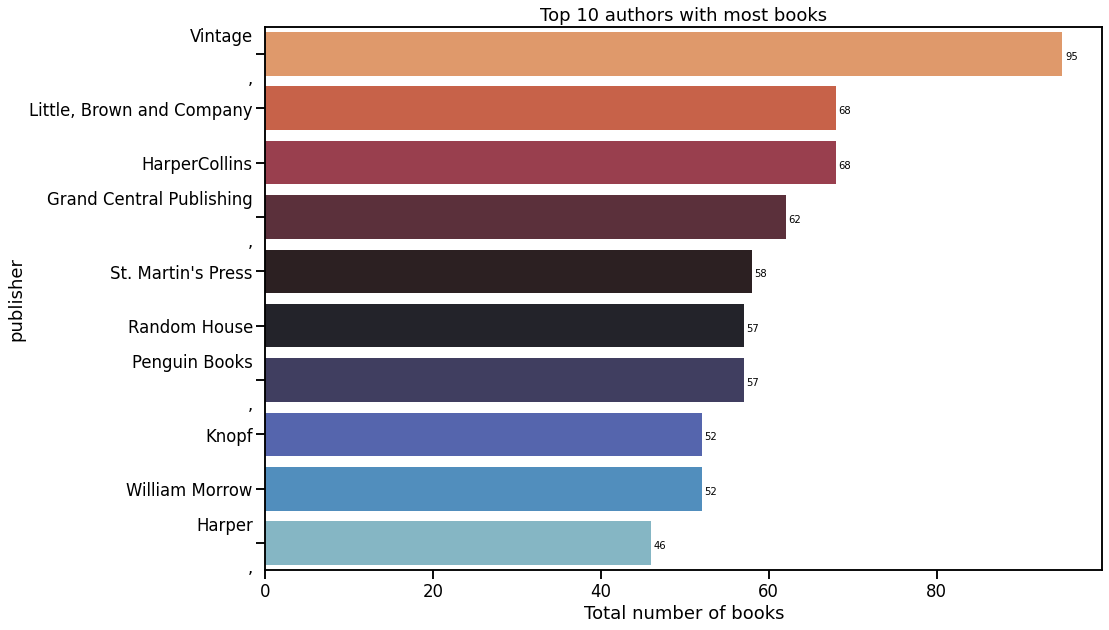

In [615]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
ax = sns.barplot(df_top_publishers['title'], df_top_publishers.index, palette='icefire_r')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

In [616]:
df_visual_genres = df_book_list.groupby('genre')['title'].count().reset_index().sort_values('title', ascending=False).head(10)
df_visual_genres

,genre,title
42,Fiction,1654
40,Fantasy,1556
112,nan,999
71,Nonfiction,783
111,Young Adult,709
49,Historical,657
66,Mystery,467
88,Romance,434
90,Science Fiction,346
50,History,322


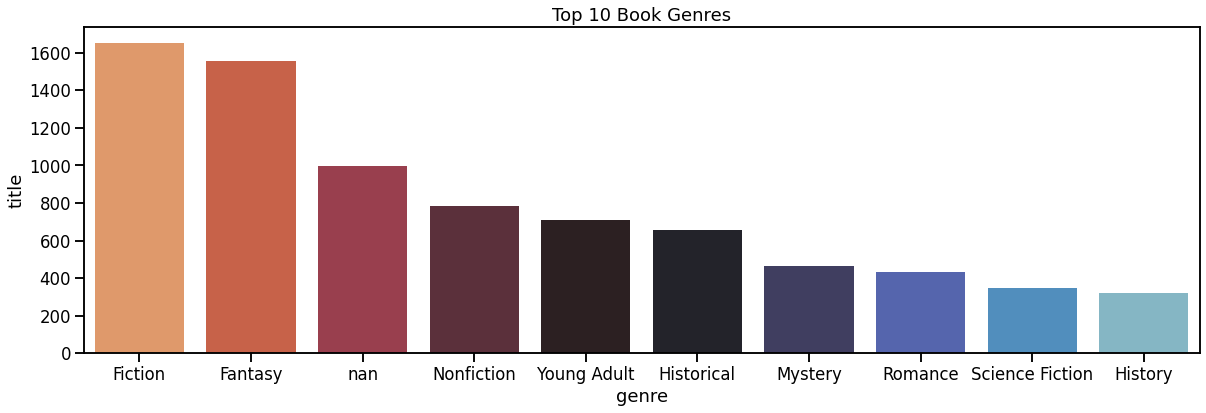

In [617]:
plt.figure(figsize=(20,6))
plt.title('Top 10 Book Genres')
sns.barplot(x="genre", y="title", data=df_visual_genres, palette='icefire_r')
plt.show()

# **Data Preparation**

Langkah langkah yang dilakukan : 
* Menghilangkan null values
* Menghilangkan data duplikat
* Menghilangkan data dengan genre 'nan'
* Data encoding Untuk data encoding, dataset yang akan digunakan hanya df atau gabungan dari kedua dataset sebelumnya karena data yang akan digunakan untuk model adalah dataset df ini. Untuk penggunaanya, saya membuat encoding atau menyandikan nilai unik dari kolom user_id. Lalu saya melakukan proses encoding angka ke user_id. Hal yang serupa saya lakukan kepada item_id. Kemudian saya memetakan hasil dari encoding tersebut ke dalam dataframe df.
* One-Hot Encoding Proses ini digunakan untuk cosine similarity. Pertama saya membuat one hot encoding pada genre karena setiap film mempunyai jumlah genre yang berbeda dan genre yang bervariasi. Saya membuat kolom baru untuk setiap nilai genre yang terdapat dalam kolom genres.
* Train Test Split data untuk Collaborative Filtering dengan ratio 80% data latih dan 20% data uji.

In [618]:
df_book_list['genre'].dropna(axis=0, inplace=True)
df_book_list['rate'].dropna(axis=0, inplace=True)

df_book_list.drop(df_book_list.loc[df_book_list['genre']== 'nan'].index, inplace=True)

In [619]:
df_book_list.isnull().sum()
print(df_book_list.shape)

(9019, 14)


In [620]:
df_book_list.drop_duplicates(subset=['title'], keep='first', inplace=True)
print(df_book_list.shape)

(8140, 14)


In [621]:
check_duplicates = df_book_list[df_book_list.duplicated()]
print(check_duplicates)

Empty DataFrame
Columns: [id, title, series, author, book_link, genre, date_published, publisher, num_of_page, lang, review_count, rating_count, rate, award]
Index: []


In [622]:
df_book_cleaned = df_book_list[['title', 'rate', 'genre', 'id']]
df_book_cleaned.head()

,title,rate,genre,id
0,The Martian,4.40,Science Fiction,0
1,Under the Banner of Heaven: A Story of Violent...,3.98,Nonfiction,1
2,Cutting for Stone,4.29,Fiction,2
3,We Need to Talk About Kevin,4.04,Fiction,3
4,The Immortal Life of Henrietta Lacks,4.07,Nonfiction,4


# Content-Based Filtering


In [623]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Data preparation untuk Cosine Similarity
tf = TfidfVectorizer(stop_words='english')

# Melakukan perhitungan idf pada data movies
tf.fit(df_book_cleaned['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['academic',
 'adult',
 'adventure',
 'africa',
 'american',
 'amish',
 'animals',
 'apocalyptic',
 'architecture',
 'art',
 'artificial',
 'asian',
 'autobiography',
 'aviation',
 'biography',
 'business',
 'childrens',
 'christian',
 'christianity',
 'cities',
 'classics',
 'computer',
 'contemporary',
 'crime',
 'criticism',
 'cultural',
 'culture',
 'dark',
 'death',
 'design',
 'dragons',
 'drama',
 'drink',
 'dungeons',
 'eastern',
 'economics',
 'education',
 'environment',
 'epic',
 'erotica',
 'european',
 'family',
 'fan',
 'fantasy',
 'feminism',
 'fiction',
 'folklore',
 'food',
 'football',
 'games',
 'gothic',
 'health',
 'help',
 'hi',
 'historical',
 'history',
 'holiday',
 'horror',
 'horticulture',
 'humanities',
 'humor',
 'ii',
 'inspirational',
 'intelligence',
 'labor',
 'language',
 'leadership',
 'lgbt',
 'literature',
 'marriage',
 'media',
 'medical',
 'music',
 'mystery',
 'mythology',
 'neurodiversity',
 'new',
 'nonfiction',
 'north',
 'northern',
 'novels'

In [624]:
tfidf_matrix = tf.fit_transform(df_book_cleaned['genre']) 
tfidf_matrix.shape

(8140, 119)

In [625]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.52326972, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.52326972, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [626]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_book_cleaned['title'],
                             columns=df_book_cleaned['title'])
print('Size dataframe:', cosine_sim_df.shape)

# Melihat similarity matrix tiap movie
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Size dataframe: (8140, 8140)


title,Ransom,Marvels: Eye of the Camera,"Captain's Fury (Codex Alera, #4)","Mozart's Sister (Ladies of History, #1)","Pathologies of Power: Health, Human Rights and the New War on the Poor",The Signal and the Noise: Why So Many Predictions Fail—But Some Don't,"Sword Art Online, Vol. 05: Phantom Bullet (Sword Art Online Light Novel, #5)",South of Darkness,Do You Realize?,"Phantom Prey (Lucas Davenport, #18)"
title,,,,,,,,,,
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
A History of Polish Christianity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
Southern Cross the Dog: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.52327,0.0
Starter for Ten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.52327,0.0
Code Name Verity,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.0
How Could She?,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00000,0.0
"Resistance (Night School, #4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
Doctor Who: Prisoner of the Daleks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
The Redheaded Princess,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.0


# Recommendation Result for Content-Based Filtering

In [633]:
def BookRecommendations(book_title, similarity_data=cosine_sim_df, 
                         items=df_book_cleaned[["id","title","genre"]], k=25):
  
    ''' Mengambil data menggunakan argpartition untuk partisi secara tidak langsung,
    sepanjang sumbu yang diberikan, kemudian dataframe diubah menjadi numpy Range 
    dengan parameter sebagai berikut (start, stop, step) '''
    index = similarity_data.loc[:, book_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop movie_title agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [634]:
# Check data lengkap sebuah title 
find_title = df_book_cleaned[df_book_cleaned['title'] == 'Wartime Farm']
find_title

,title,rate,genre,id
5732,Wartime Farm,4.36,History,5732


In [635]:
book_suggestion = BookRecommendations(book_title = 'Wartime Farm')
book_suggestion

,title,id,genre
0,The Swerve: How the World Became Modern,1951,History
1,A More Unbending Battle: The Harlem Hellfighte...,6651,History
2,"The Witches: Salem, 1692",8933,History
3,Champlain's Dream,8950,History
4,"A World Undone: The Story of the Great War, 19...",4440,History
5,"The Devil's Chessboard: Allen Dulles, the CIA,...",6617,History
6,Angry Aztecs,8966,History
7,The Republic of Pirates: Being the True and Su...,8978,History
8,"Wine and War: The French, the Nazis, and the B...",8987,History
9,The Fall of Berlin 1945,1856,History
